# Cross batch matching in MOSTA dataset

We present our evaluation source code of cross batch matching in the MOSTA slice E14,5 and E 15.5 in this section.

## Data Preparation

First, we obtain the adata fromat data by `st_datasets`.

In [1]:
import scanpy as sc
import numpy as np

import st_datasets as stds
from train_integrate import train_integration
from stMSA.utils import find_similar_index, plotting


process_tag = 'E14.5_E15.5'
urls = [
    'https://ftp.cngb.org/pub/SciRAID/stomics/STDS0000058/stomics/E14.5_E1S1.MOSTA.h5ad',
    'https://ftp.cngb.org/pub/SciRAID/stomics/STDS0000058/stomics/E15.5_E1S1.MOSTA.h5ad',
]
adata_list = []

for i in range(2):
    adata, _ = stds.get_data(stds.get_outside_data, url=urls[i], top_genes=5000)
    adata = adata[:, adata.var['highly_variable']]
    adata.obs['cluster'] = adata.obs['annotation']
    adata_list.append(adata)

adatas = sc.concat(adata_list, label='batch')
print(f'>>> INFO: Input adata shape {adatas.X.shape}')

>>> INFO: Use local data.
>>> INFO: dataset name: Outside dataset, size: (102519, 28463), cluster: None.(12.252s)
>>> INFO: Use local data.
>>> INFO: dataset name: Outside dataset, size: (113350, 28798), cluster: None.(8.059s)
>>> INFO: Input adata shape (215869, 2068)


## Train stMSA

Then, we can learn the latent representation by stMSA.

In [2]:
adatas = train_integration(adatas, radius=1.3)

>>> INFO: Generate 510605 edges, 3.981 edges per spot.(0.931s)
>>> INFO: Generate 564846 edges, 3.983 edges per spot.(0.821s)
>>> INFO: Finish generate precluster embedding(128.765s)!


  0%|          | 1/500 [00:24<3:25:38, 24.73s/it]

>>> INFO: Finish finding mmn pairs, find 1999124 mnn node pairs(21.480s)!


 20%|██        | 101/500 [01:31<50:31,  7.60s/it]

>>> INFO: Finish finding mmn pairs, find 3604765 mnn node pairs(21.665s)!


 40%|████      | 201/500 [02:41<38:22,  7.70s/it]

>>> INFO: Finish finding mmn pairs, find 3854279 mnn node pairs(21.948s)!


 60%|██████    | 301/500 [03:51<24:55,  7.52s/it]

>>> INFO: Finish finding mmn pairs, find 3973697 mnn node pairs(21.566s)!


 80%|████████  | 401/500 [05:02<12:54,  7.82s/it]

>>> INFO: Finish finding mmn pairs, find 4049284 mnn node pairs(22.296s)!


100%|██████████| 500/500 [05:49<00:00,  1.43it/s]


## Matching

Next, we can obtain the matching result by `stMSA.utils.find_similar_index`.

In [3]:
src = adatas['0' == adatas.obs['batch']]
dst = adatas['1' == adatas.obs['batch']]

_, order = find_similar_index(
    src.obsm['embedding'], 
    dst.obsm['embedding'], 
)
matching_score = np.sum(src.obs['cluster'].to_numpy() == dst[order.reshape(-1)].obs['cluster'].to_numpy()) / src.X.shape[0]

print(f'>>> INFO: matching score:', matching_score)

>>> INFO: matching score: 0.6671836440074522


## Visualization

Moreover, we visualized the matching result by `stMSA.utils.plotting`.

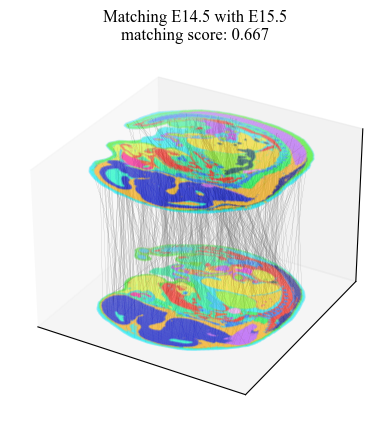

In [4]:
plotting(
    coor_list=[np.vstack([coor_1.T, np.ones((1, coor_1.shape[0]))]), np.vstack([coor_2.T, np.ones((1, coor_2.shape[0]))])],
    label_list=[adata['0' == adata.obs['batch']].obs['cluster'].to_numpy(), adata['1' == adata.obs['batch']].obs['cluster'].to_numpy()],
    save_path='matching_result.pdf',
    dims='3d',
    norm_coor=True,
    spot_size=1e-3,
    line_list=np.hstack([np.arange(src.shape[0]).reshape(-1, 1), order]).reshape(1, -1, 2)[:, np.random.randint(low=0, high=src.shape[0], size=500), :],
    title=f'Matching E14.5 with E15.5\nmatching score: {matching_score:.3f}'
)